# *Alman Trafik İşaretlerini Tanıyan Akıllı Sistem: Görüntüden Anlık Tahmin*

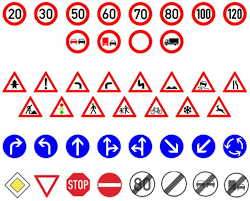

*Bu projede, Kaggle’daki “German Traffic Sign Recognition Benchmark (GTSRB)” veri seti kullanılarak, Almanya’daki trafik işaretlerini tanıyabilen bir derin öğrenme modeli geliştirilmiştir. Model, Convolutional Neural Network (CNN) tabanlı olup farklı trafik işaretlerini yüksek doğrulukla sınıflandırabilmektedir.*

*Geliştirilen sistem, kullanıcıların bir trafik işaretinin fotoğrafını yüklediğinde işaretin türünü anlık olarak tahmin edebilmektedir.*

### *İmport*

In [1]:
# OpenCV kütüphanesini import ediyoruz, görüntü işleme ve video/frame işlemleri için kullanılır
import cv2

# Pandas kütüphanesini import ediyoruz, veri analizi ve tablo şeklinde veri yönetimi için kullanılır
import pandas as pd

# NumPy kütüphanesini import ediyoruz, sayısal hesaplamalar ve matris işlemleri için kullanılır
import numpy as np

# scikit-learn kütüphanesinden train_test_split fonksiyonunu import ediyoruz,
# veriyi eğitim ve test setlerine ayırmak için kullanılır
from sklearn.model_selection import train_test_split

# Keras kütüphanesinden gerekli modülleri import ediyoruz
# Sequential: katman katman model oluşturmak için
# Conv2D: 2D evrişim katmanı (görüntülerde özellik çıkarımı için)
# Dense: tam bağlantılı katman (sınıflandırma veya regresyon için)
# Flatten: çok boyutlu veriyi tek boyuta indirger
# Input: modelin giriş katmanı
# MaxPooling2D: evrişim katmanından sonra boyut küçültmek için max pooling uygular
# Dropout: aşırı öğrenmeyi (overfitting) önlemek için rastgele nöronları kapatır
# BatchNormalization: modelin daha hızlı ve stabil öğrenmesini sağlar
# Reshape: verinin şeklini değiştirmek için
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization, Reshape

# İşletim sistemi ile ilgili işlemler yapmak için os modülünü import ediyoruz
# Örneğin dosya/dizin kontrolleri, dosya yolları oluşturma gibi
import os

In [2]:
# Python'da uyarı mesajlarını yönetmek için warnings modülünü import ediyoruz
import warnings

# Tüm uyarı mesajlarını görmezden gelmek için filterwarnings ile 'ignore' ayarını yapıyoruz
# Bu sayede ekranda gereksiz uyarılar görünmez ve kod çıktısı daha temiz olur
warnings.filterwarnings('ignore')

In [14]:
from tensorflow.keras.utils import to_categorical

### *CSV Dosyalarını Oku*

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [7]:
# Dataset yolunu kendi path’in ile değiştir
dataset_path = "/kaggle/input/gtsrb-german-traffic-sign"

train_csv = pd.read_csv(os.path.join(dataset_path, "Train.csv"))
test_csv = pd.read_csv(os.path.join(dataset_path, "Test.csv"))
meta_csv = pd.read_csv(os.path.join(dataset_path, "Meta.csv"))

print("Eğitim verisi örnekleri:")
print(train_csv.head())

Eğitim verisi örnekleri:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


### *Görüntüleri ve Etiketleri Hazırla*

In [15]:
from tqdm import tqdm

IMG_SIZE = 32  # Küçük boyut, CNN için yeterli

x = []
y = []

for index, row in tqdm(train_csv.iterrows()):
    # CSV'deki Path zaten doğru yolu içeriyor, ekstra "Train" ekleme
    img_path = os.path.join(dataset_path, row['Path'])

    # Görüntüyü oku
    img = cv2.imread(img_path)

    # Eğer görüntü okunamazsa hata vermesin
    if img is None:
        print("Görüntü okunamadı:", img_path)
        continue

    # Yeniden boyutlandır
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    x.append(img)
    y.append(row['ClassId'])

x = np.array(x, dtype='float32') / 255.0  # Normalize et
y = np.array(y)

# One-hot encode etiketler
num_classes = len(meta_csv)
y = to_categorical(y, num_classes)

print("Veri şekli:", x.shape, y.shape)

39209it [01:17, 504.81it/s]


Veri şekli: (39209, 32, 32, 3) (39209, 43)


In [16]:
# Veriyi eğitim ve test setlerine ayırıyoruz
# x → görüntü verileri (girdi)
# y → etiketler (çıktı)
# test_size=0.20 → verinin %20'si test seti, %80'i eğitim seti olacak
# random_state=42 → rastgele bölme işleminin tekrarlanabilir olmasını sağlar
#                  42 sadece farklı bir sabit sayı, aynı sayıyı her kullanışta aynı bölme elde edilir
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [17]:
# Eğitim etiketlerini NumPy dizisine çeviriyoruz ve veri tipini int32 olarak belirliyoruz
y_train = np.array(y_train, dtype=np.int32)

# Test etiketlerini NumPy dizisine çeviriyoruz ve veri tipini int32 olarak belirliyoruz
y_test = np.array(y_test, dtype=np.int32)

### *Modelling*

In [19]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Modeli eğitim verisiyle eğitiyoruz
history = model.fit(
    x_train,              # Girdi verileri (görüntüler)
    y_train,              # Hedef etiketler (0 veya 1)
    validation_data=(x_test, y_test),  # Her epoch sonunda test verisi ile doğrulama
    epochs=15,            # Modelin tüm eğitim verisi üzerinden 20 kez geçmesi
    verbose=1             # Eğitim sırasında ilerleme çubuğunu göster
)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.3568 - loss: 2.3989 - val_accuracy: 0.9106 - val_loss: 0.3669
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step - accuracy: 0.8291 - loss: 0.5445 - val_accuracy: 0.9699 - val_loss: 0.1275
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.9026 - loss: 0.3121 - val_accuracy: 0.9814 - val_loss: 0.0842
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9276 - loss: 0.2352 - val_accuracy: 0.9846 - val_loss: 0.0605
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.9447 - loss: 0.1781 - val_accuracy: 0.9869 - val_loss: 0.0492
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 91s 55ms/step - accuracy: 0.9563 - loss: 0.1447 - val_accuracy: 0.9915 - val_loss: 0.0390
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - accuracy: 0.9616 - loss: 0.1225 - val_accuracy: 0.9915 - val_loss: 0.0333
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.9672 - loss: 0.1041 - 

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9961 - loss: 0.0173
Test Accuracy: 0.9954093098640442


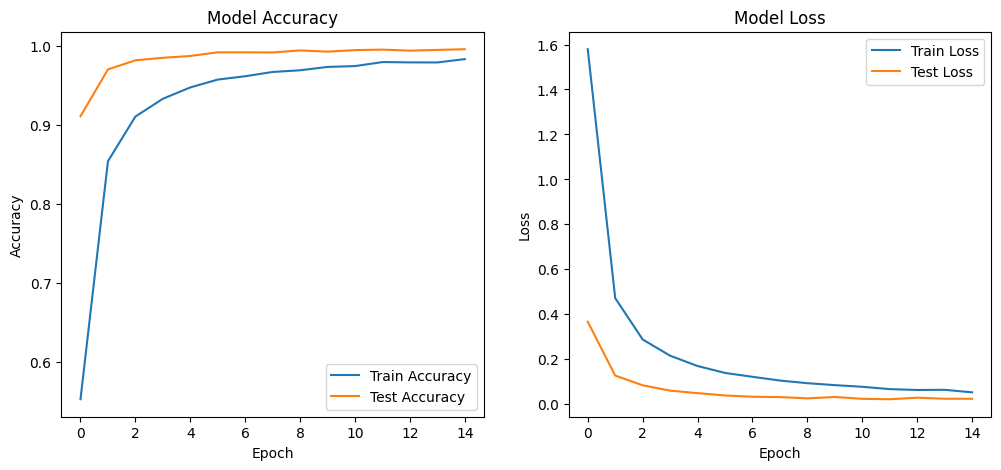

In [22]:
import matplotlib.pyplot as plt

# Accuracy ve Loss grafiklerini çizme
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
model.save('gtsrb_traffic_sign_model.keras')

*Bu projede geliştirilen derin öğrenme modeli, Almanya’daki trafik işaretlerini yüksek doğrulukla tanıyabilmekte ve kullanıcıların bir resim yükleyerek işaretleri anlık olarak sınıflandırmasına olanak sağlamaktadır.*